# 分类

## 蠓虫分类

生物学家试图对两类蠓虫(Af与Apf)进行鉴别,依据的资料是蠓虫的触角和翅膀的长度,已经测得9只Af和6只Apf的数据,制定一种方法,正确区分两类蠓虫。有三个新样本：(1.80, 1.24)，(1.84, 1.28)，(2.04, 1.40)，试确定它们的种类。



- Af

|                   |      |      |      |      |      |      |      |      |      |
|-------------------|------|------|------|------|------|------|------|------|------|
|Wing length (cm)   | 1.72 | 1.64 | 1.74 | 1.7  | 1.82 | 1.82 | 1.9  | 1.82 | 2.08 |
|Antenna length (cm)| 1.24 | 1.38 | 1.36 | 1.4  | 1.38 | 1.48 | 1.38 | 1.54 | 1.56 |

- Apf

|                   |      |      |      |      |      |      |
|-------------------|------|------|------|------|------|------|
|Wing length (cm)   | 1.78 | 1.86 | 1.96 | 2.0  | 2.0  | 1.96 | 
|Antenna length (cm)| 1.14 | 1.2  | 1.3  | 1.26 | 1.28 | 1.18 |


    Wing (cm)  Antenna (cm) Kind   Dataset
0        1.72          1.24   Af  Training
1        1.64          1.38   Af  Training
2        1.74          1.36   Af  Training
3        1.70          1.40   Af  Training
4        1.82          1.38   Af  Training
5        1.82          1.48   Af  Training
6        1.90          1.38   Af  Training
7        1.82          1.54   Af  Training
8        2.08          1.56   Af  Training
9        1.78          1.14  Apf  Training
10       1.86          1.20  Apf  Training
11       1.96          1.30  Apf  Training
12       2.00          1.26  Apf  Training
13       2.00          1.28  Apf  Training
14       1.96          1.18  Apf  Training


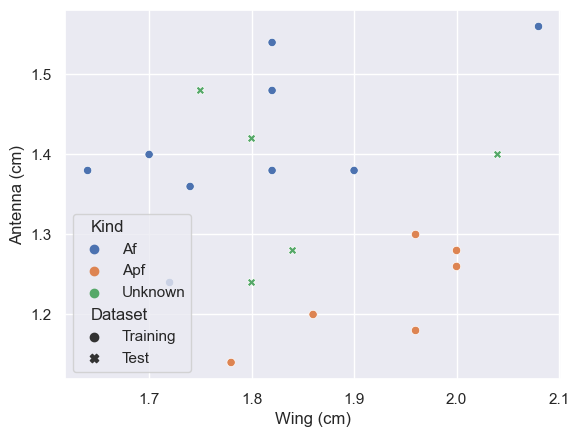

In [1]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import LabelEncoder

data = pd.DataFrame(
    {
        'Wing (cm)':    [1.72, 1.64, 1.74, 1.7 , 1.82, 1.82, 1.9 , 1.82, 2.08, 1.78, 1.86, 1.96, 2.  , 2.  , 1.96],
        'Antenna (cm)': [1.24, 1.38, 1.36, 1.4 , 1.38, 1.48, 1.38, 1.54, 1.56, 1.14, 1.2 , 1.3 , 1.26, 1.28, 1.18],
        'Kind':         ['Af'] * 9 + ['Apf'] * 6,
        'Dataset':      'Training'
    }
)

print(data)

test = pd.DataFrame(
    {
        'Wing (cm)':    [1.80, 1.84, 2.04, 1.80, 1.75],
        'Antenna (cm)': [1.24, 1.28, 1.40, 1.42, 1.48],
        'Kind':         ['Unknown'] * 5,
        'Dataset':      'Test'
    }
)


le = LabelEncoder()
le.fit(['Af', 'Apf', 'Unknown'])

sns.set_theme()
sns.scatterplot(data=pd.concat([data, test]), x='Wing (cm)', y='Antenna (cm)', hue='Kind', style='Dataset');


## 无监督学习

### Kmeans

按照最近距离进行聚类


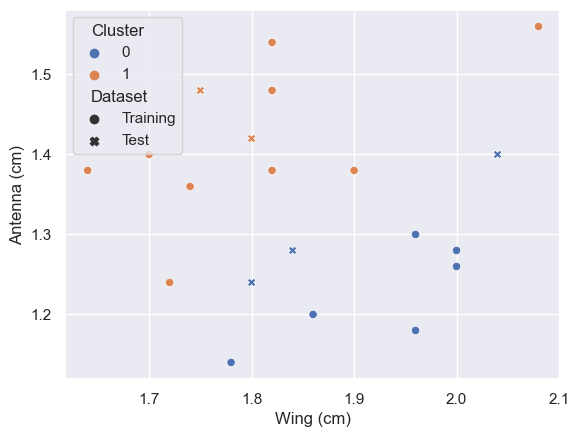

In [2]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans.fit(data.loc[:, 'Wing (cm)':'Antenna (cm)'])
pred = kmeans.predict(test.loc[:, 'Wing (cm)':'Antenna (cm)'])
test['Cluster'] = pred
data['Cluster'] = kmeans.labels_

sns.scatterplot(data=pd.concat([data, test]), x='Wing (cm)', y='Antenna (cm)', hue='Cluster', style='Dataset');

### 混合高斯模型 (Gaussian Mixture)

使用多个高斯模型进行叠加

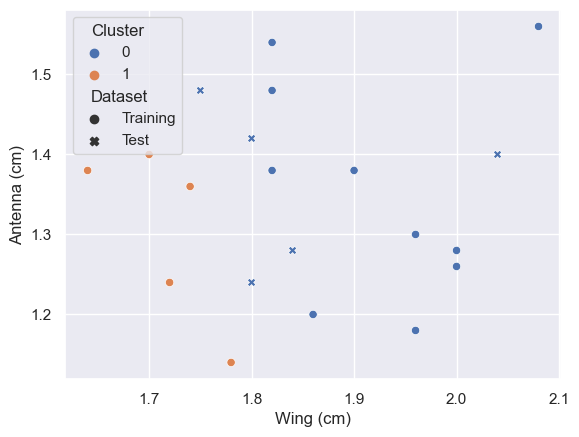

In [3]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=2)
gm.fit(data.loc[:, 'Wing (cm)':'Antenna (cm)'])
pred = gm.predict(test.loc[:, 'Wing (cm)':'Antenna (cm)'])
test['Cluster'] = pred
data['Cluster'] = gm.predict(data.loc[:, 'Wing (cm)':'Antenna (cm)'])

sns.scatterplot(data=pd.concat([data, test]), x='Wing (cm)', y='Antenna (cm)', hue='Cluster', style='Dataset');

## 有监督学习
### KNN

所谓K最近邻，就是k个最近的邻居的意思，说的是每个样本都可以用它最接近的k个邻居来代表。

![](images/knn.png)

用KNN来解决蠓虫分类问题：

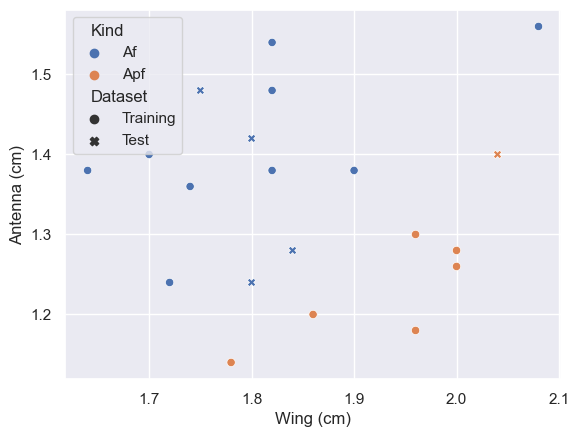

In [4]:
from sklearn.neighbors import KNeighborsClassifier

# 根据3个最近邻进行分类
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(data.loc[:, 'Wing (cm)':'Antenna (cm)'], le.transform(data['Kind']))
pred = knn.predict(test.loc[:, 'Wing (cm)':'Antenna (cm)'])
test['Kind'] = le.inverse_transform(pred)

sns.scatterplot(data=pd.concat([data, test]), x='Wing (cm)', y='Antenna (cm)', hue='Kind', style='Dataset');

### 支持向量机(SVM)

支持向量机（Support Vector Machine，SVM）是一种监督学习算法。它通过在特征空间中构建超平面来将数据分为不同的类别或预测连续值。SVM 的主要思想是找到一个最优的超平面，使得不同类别的数据点在超平面的两侧尽可能地分开，同时最大化间隔。这个最优超平面是通过选择支持向量（Support Vector）来确定的，这些支持向量是离超平面最近的数据点。SVM 具有很高的准确性和泛化能力，适用于高维数据和小样本数据。

<img src="./images/svm.png" width="50%" height=50%/>

![](./images/svm-kernel.webp)


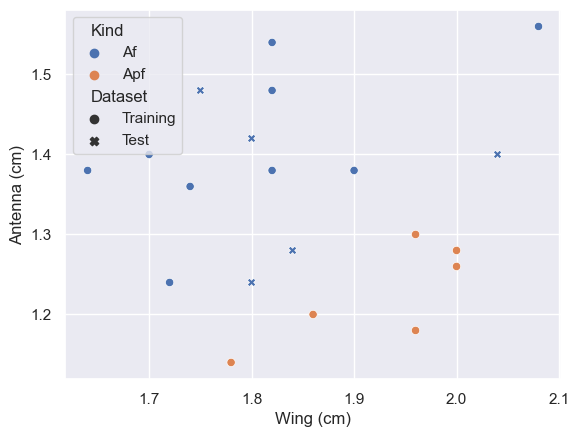

In [5]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1)
svm.fit(data.loc[:, 'Wing (cm)':'Antenna (cm)'], le.transform(data['Kind']))
pred = svm.predict(test.loc[:, 'Wing (cm)':'Antenna (cm)'])
test['Kind'] = le.inverse_transform(pred)

sns.scatterplot(data=pd.concat([data, test]), x='Wing (cm)', y='Antenna (cm)', hue='Kind', style='Dataset');

### 决策树

<img src="./images/decision-tree.png" width="50%" height="50%" />


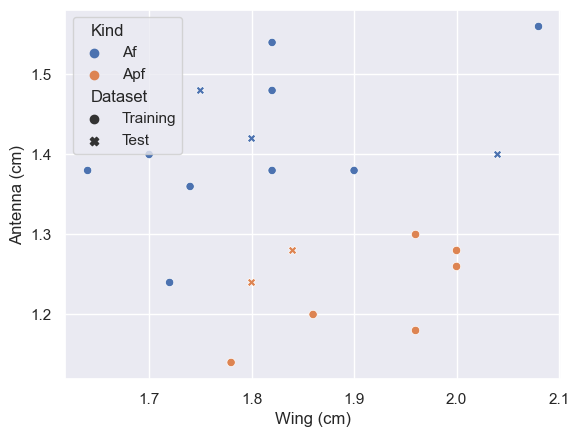

In [6]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5)
dt.fit(data.loc[:, 'Wing (cm)':'Antenna (cm)'], le.transform(data['Kind']))
pred = dt.predict(test.loc[:, 'Wing (cm)':'Antenna (cm)'])
test['Kind'] = le.inverse_transform(pred)

sns.scatterplot(data=pd.concat([data, test]), x='Wing (cm)', y='Antenna (cm)', hue='Kind', style='Dataset');

### 随机森林

<img src="./images/random-forest.png" width="60%" height="60%" />

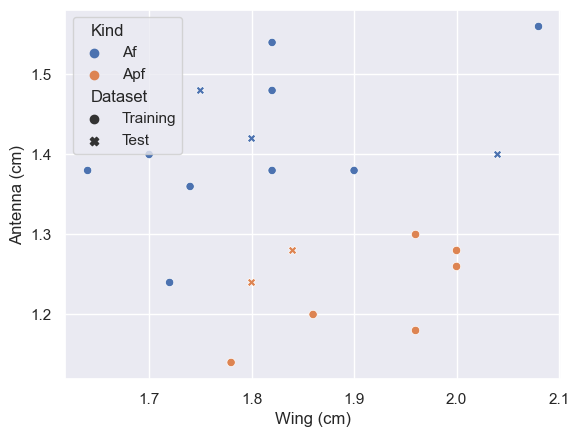

In [7]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(data.loc[:, 'Wing (cm)':'Antenna (cm)'], le.transform(data['Kind']))
pred = rf.predict(test.loc[:, 'Wing (cm)':'Antenna (cm)'])
test['Kind'] = le.inverse_transform(pred)

sns.scatterplot(data=pd.concat([data, test]), x='Wing (cm)', y='Antenna (cm)', hue='Kind', style='Dataset');

## 鸢尾花的分类(Fisher’s Irises)

Fisher's Irises数据集中的一个简单例子，该数据集记录了150个鸢尾花标本及其一些特征：

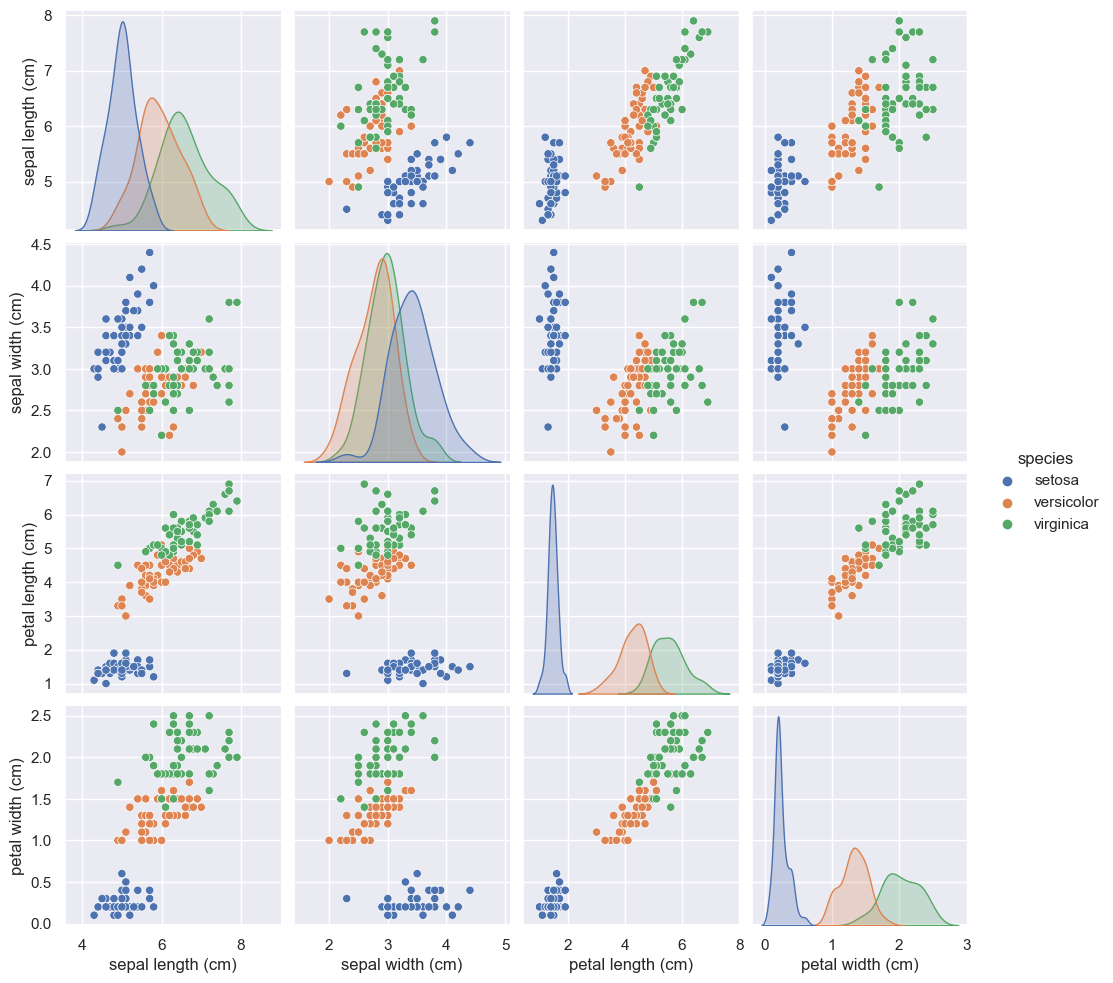

In [8]:
from sklearn.datasets import load_iris
import pandas as pd

iris = load_iris()
data = pd.DataFrame(data=iris.data, columns=iris.feature_names)
data['species'] = iris.target_names[iris.target]

sns.pairplot(data=data, hue="species");

## 尝试用不同方法对鸢尾花进行分类

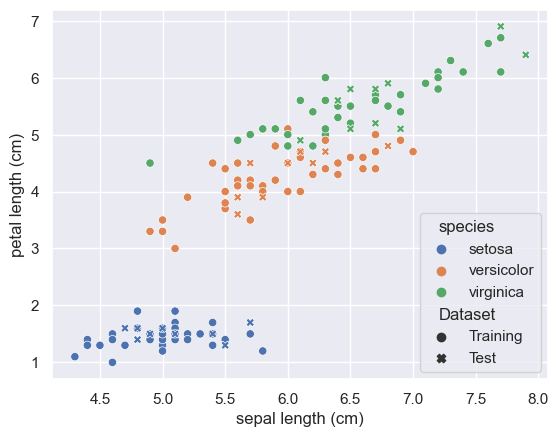

In [9]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

le = LabelEncoder()
le.fit(['setosa', 'versicolor', 'virginica'])

train_data['Dataset'] = 'Training'
test_data['Dataset'] = 'Test'

svm = SVC(kernel='rbf', C=1)
svm.fit(train_data.iloc[:, 0:4], le.transform(train_data['species']))
pred = svm.predict(test_data.iloc[:, 0:4])
test_data['species'] = le.inverse_transform(pred)

sns.scatterplot(data=pd.concat([train_data, test_data]), x='sepal length (cm)', y='petal length (cm)', hue='species', style='Dataset');